## Chapter 19. Clustering

***Clustering*** = unsupervised learning = completely unlabeled data (or data has labels but we ignore them)

### The Idea
Whenever you look at some source of data, it’s likely it will somehow form clusters. A data set showing where millionaires live probably has clusters in places like Beverly Hills and Manhattan. A data set showing how many hours people work each week
probably has a cluster around 40.. A data set of demographics of registered voters likely forms a variety of clusters (e.g., “soccer moms,” “bored retirees,” “unemployed millennials”) that pollsters + political consultants likely consider relevant.

Generally no “correct” clustering. An alternative clustering scheme might group some of the “unemployed millenials” w/ “grad students,” others w/ “parents’ basement dwellers.” Neither scheme is necessarily more correct + each is likely more optimal w/ respect to its own “how good are the clusters?” metric.

Furthermore, the **clusters won’t label themselves. You’ll have to do that by looking at the data underlying each one.**

### The Model

For us, each input = vector in d-dimensional space (represented as a list of #'s) w/ goal = ID clusters of similar inputs + (sometimes) to find a representative value for each cluster.

* Ex: each input could be a numeric vector that somehow represents the title of a blog post, in which case goal might be = find clusters of similar posts, perhaps in order to understand what users are blogging about
* Ex: Have a picture containing thousands of RGB colors we need to screen-print a 10-color version of = Clustering can help us choose 10 colors that will minimize total “color error.”

1 of simplest clustering methods = **k-means** = # of clusters `k` (chosen in advance) after which goal is to partition inputs into sets in a way that minimizes TSS distances from each point to the mean of its assigned cluster.

There are a lot of ways to assign n points to k clusters, which means finding an optimal clustering = very hard problem. Can settle for an iterative algorithm that usually finds a good clustering:
1. Start w/ a set of *k-means* = points in d-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point’s assignment has changed, stop + keep the clusters.
4. If some point’s assignment change, recompute the means + return to step 2.

Using `vector_mean()`, it’s pretty simple to create a class that does this:

In [1]:
import sys
import random

sys.path.insert(0, './../../../00_DataScience/DSFromScratch/code')

from linear_algebra import vector_mean, squared_distance, distance

class Kmeans:
    """Performas k-means clustering"""
    
    def __init__(self,k):
        self.k = k          # number of clusters
        self.means = None   # means of clusters
    
    def classify(self, input):
        """Returns index of cluster closest to given input"""
        # compute squared distance of each input from each of the cluster means
        # and return the index of the minimum squared_distance
        return min(range(self.k),
                  key=lambda i: squared_distance(input, self.means[i]))
    
    def train(self,input):
        # choose k random points as initial means
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            # find new assignments by classifying each input point
            new_assignments = list(map(self.classify, inputs))
            
            # check if assignments changed and end if not
            if assignments == new_assignments:
                return
            
            # if changed, keep new assigments
            assignments = new_assignments
            
            for i in range(self.k):
                i_points = [p for p,a in zip(inputs,assignments) if a == i]
                # avoids dividing by 0 if i_points = empty
                if i_points:
                    self.means[i] = vector_mean(i_points)

### Ex: Meetups

VP of User Rewards wants to organize several in-person meetups for hometown users. we know locations of all local users.

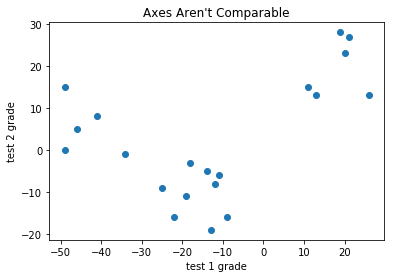

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt

inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

plt.scatter([input[0] for input in inputs],[input[1] for input in inputs])
plt.title("Axes Aren't Comparable")
plt.xlabel("test 1 grade")
plt.ylabel("test 2 grade")
plt.show()

Wants us to choose meetup locations that make it convenient for everyone to attend. We see 2-3 clusters. (easy to do visually b/c data is only 2D + more dimensions = harder). Imagine we have enough budget for 3 meetups.

In [3]:
random.seed(0) # so you get the same results as me
clusterer = Kmeans(3) # start with 3 clusters
clusterer.train(inputs)
print(clusterer.means)

[[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]


Find 3 clusters centered at [-25.85, -4.71], [20.0, 26.0], and [16.67, 13.67], and you look for meetup venues near those locations. Show it to the VP, who informs you that now she only has enough budget for 2 meetups.

In [4]:
random.seed(0) # so you get the same results as me
clusterer = Kmeans(2) # start with 3 clusters
clusterer.train(inputs)
print(clusterer.means)

[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]


One meetup should still be near [-25.85, -4.71], but the other is now near [18.33, 19.83]

### Choosing k

Previous example = choice of k = driven by factors outside our control. In general, won’t be the case. There's a wide variety of ways to choose a k. 1 reasonably easy to understand way = plotting the SEE (between each DP + mean of its cluster) as a function of k and looking at where the graph “bends”/has an "elbow"

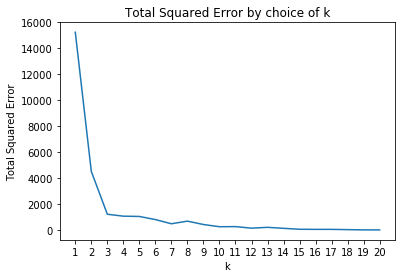

In [5]:
def squared_cluster_errors(inputs,k):
    """Finds Total Squared Error from k-means clustering on inputs"""
    
    clusterer = Kmeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    
    assignments = map(clusterer.classify,inputs)
    
    return sum(squared_distance(input,means[cluster])
               for input,cluster in zip(inputs,assignments))

# plot from k=1 upward to length(inputs)
ks = range(1,len(inputs)+1)
errors = [squared_cluster_errors(inputs,k) for k in ks]

plt.plot(ks,errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("Total Squared Error")
plt.title("Total Squared Error by choice of k")
plt.show()

This method agrees w/ original eyeballing for k = 3 = “right” # of clusters.

### Example: Clustering Colors

VP of Product Marketing = designed attractive stickers to hand out at meetups. Unfortunately, the printer can print at most 5 colors per sticker, VP of Art = on sabbatical, + we need some way to take the design + modify it so that it only contains 5 colors.

CPU images can be represented as 2D array of pixels, each itself a 3D vector (RGB) indicating its color. Creating a 5-color version of the image then entails:
1. Choosing 5 colors
2. Assigning 1 color to each pixel

This = a great task for k-means clustering, which can partition pixels into 5 clusters in a RGB space + then recolor pixels in each cluster to the mean color. To start, load image into Python w/ matplotlib:

In [6]:
#import matplotlib.image as mpimg

#path_to_png_file = r"./img.jpg" 
#img = mpimg.imread(path_to_png_file)

BTS, `img` = NumPy array, but for our purposes, treat it as a list of lists of lists where `img[i][j]` = pixel in ith row + jth col, + each pixel = a list `[R,G,B]` of #'s between 0-1 indicating the color of that pixel:

In [7]:
#print(img)

In [8]:
#top_row = img[0]
#top_left_px = top_row[0]
#red,green,blue = top_left_px
#print(red,green,blue)

In particular, can get a flattened list of all pixels, plug them into the clusterer, then construct a new image with the same format

In [9]:
# flattened list of all pixels
#pxls = [px for row in img for px in row]

#clusterer = Kmeans(5) # 5-color printer
#clusterer.train(pxls)

# construct new image
#def recolor(px):
#    cluster = clusterer.classify(px) # index of closest cluster
#    return clusterer.means[cluster] # mean of closest cluster

# recolor row of pixels each row in image
#new_img = [[recolor(px) for px in row] for row in img]

In [10]:
# clusterer.classify(pxls[1]) # = 4
#clusterer.means[4]

In [11]:
#pxls = [px for row in img for px in row]
#pxls[0:5]

In [12]:
#clusterer = KMeans(5) # 5-color printer
#clusterer.train(pxls)
#pxls[1]

In [13]:
#pxls[1]

In [14]:
#clusterer.classify(px) # index of closest cluster

In [15]:
# construct new image
#def recolor(px):
#    cluster = clusterer.classify(px) # index of closest cluster
#    return clusterer.means[cluster] # mean of closest cluster

In [16]:
#display images
#plt.imshow(img)
#plt.axis("off")
#plt.show()

In [17]:
#display images
#plt.imshow(new_img)
#plt.axis("off")
#plt.show()
#[[recolor(px) for px in row] for row in img]

In [18]:
#import numpy as np

#def recolor_image(input_file, k=5):

 #   img = mpimg.imread(path_to_png_file)
 #   pixels = [pixel for row in img for pixel in row]
  #  clusterer = Kmeans(k)
 #   clusterer.train(pixels) # this might take a while

  #  def recolor(pixel):
  #      cluster = clusterer.classify(pixel) # index of the closest cluster
  #      return clusterer.means[cluster]     # mean of the closest cluster
#
  #  new_img = [[recolor(pixel) for pixel in row]
  #             for row in img]

  #  np.expand_dims(new_img,axis=0)
    
  #  plt.imshow(new_img)
  #  plt.axis('off')
  #  plt.show()

#
#a = np.array([1,2,3,4,5])
#a = np.expand_dims(a, axis=0)
#recolor_image(img,5)

In [19]:
def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False
    
#valid_imshow_data(new_img)

### Bottom-up Hierarchical Clustering

Alternative approach to clustering = “grow” clusters from the bottom up:

1. Make each input its own cluster of one.
2. As long as there're multiple clusters remaining, find 2 closest clusters + merge them

At the end, we’ll have 1 giant cluster containing all inputs. If we keep track of the
merge order, can recreate any # of clusters by *unmerging* (Ex:, if we want 3 clusters, just undo the last 2 merges). We’ll use a really simple representation of clusters, + values will live in **leaf clusters** represented as **1-tuples**:

In [20]:
# need trailing commas to make 1-tuples or else ()'s are treated as normal ()'s
leaf1 = ([10,20],)
leaf2 = ([30,-15],)

Use these to grow merged clusters represented as 2-tuples `(merge order, children)`:

In [21]:
merged = (1,[leaf1,leaf2])

Now, create a few **helper functions**:

In [22]:
def is_leaf(cluster):
    """A cluster = a leaf if length = 1"""
    return len(cluster) == 1

def get_children(cluster):
    """Returns the 2 children of cluster if cluster is merged, and 
    raises exception if cluster is a leaf"""
    if is_leaf(cluster):
        raise TypeError("A leaf cluster has no children")
    else:
        return cluster[1]
    
def get_values(cluster):
    """Returns value (1-tuple) in cluster (if a leaf) or all values
    in leaf clusters below it (if not a leaf)"""
    if is_leaf(cluster):
        return cluster
    else:
        return [value
               for child in get_children(cluster)
               for value in get_values(child)]

In order to merge closest clusters: need some notion of distance between clusters = use the *minimum* distance between elements of the 2 clusters (merges the 2 clusters closest to touching, but will sometimes produce large chain-like clusters that aren’t very tight). 

To get tight spherical clusters, might use the *maximum* distance instead, as it merges the 2 clusters that fit in the smallest ball. Both are common choices, as is *average* distance:


In [23]:
def cluster_dist(cluster1,cluster2,distance_agg=min):
    """Compute pairwise distances between clusters 1 and 2 and
    apply distance_agg to resulting list"""
    return distance_agg([distance(input1,input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

Use the merge order slot to track the merging order: Smaller #'s = later merges, which means we want to unmerge clusters from lowest merge order to highest. 

Since leaf clusters = never merged (= never want to unmerge), assign them `infinity`:

In [24]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('int')
    else:
        return cluster[0] # merge_order = 1st element of 2-tuple

Now create the clustering algorithm:

In [25]:
def bottom_up_cluster(inputs,distance_agg=min):
    # start w/ every input as a leaf cluster/ a 1-tuple
    clusters = [(input,) for input in inputs]
    
    while len(clusters) > 1: # as long as we have > 1 cluster left
        # find 2 closest clusters
        c1,c2 = min([(cluster1,cluster2)
                    for i,cluster1 in enumerate(clusters)
                    for cluster2 in clusters[:i]],
                   key=lambda p: cluster_dist(p[0], p[1], distance_agg))
        
        # remove merged clusters from list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # merge the clusters w/ merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1,c2])
        
        # add back in their merge
        clusters.append(merged_cluster)
    
    return clusters[0] # return cluster if only 1 is left

Now use it.

In [26]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

base_cluster = bottom_up_cluster(inputs)
print(base_cluster) # ugly representation

(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])


For every merged cluster, if we say “cluster 0” for cluster w/ merge order 0, interpret this as:
* Cluster 0 = merger of cluster 1 and cluster 2.
* Cluster 1 = merger of cluster 3 and cluster 16.
* Cluster 16 = merger of the leaf [11, 15] and the leaf [13, 13].
* And so on…

Since we had 20 inputs, it took 19 merges to get 1 cluster + 1st merge created
cluster 18 by combining leaves `[19, 28]` and `[21, 27]` + last merge created
cluster 0.

Generally, don’t like nasty text representations like this (could be interesting exercise to create a user-friendlier viz of cluster hierarchy), so instead write a function that generates any # of clusters by performing appropriate # of unmerges:

[[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]], [[19, 28], [21, 27], [20, 23], [26, 13]], [[11, 15], [13, 13]]]


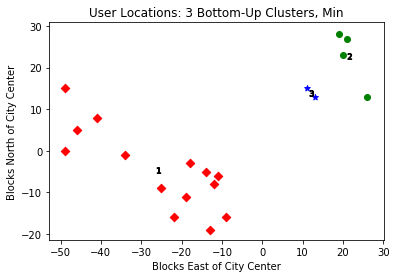

In [29]:
def generate_clusters(base_cluster, num_clusters):
    # start w/ list w/ just base cluster
    clusters = [base_cluster]
    
    # as long as we don't have enough clusters yet
    while len(clusters) < num_clusters:
        # choose last-merged cluster
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from list
        clusters = [c for c in clusters if c != next_cluster]
        # add its children to list (unmerge it)
        clusters.extend(get_children(next_cluster))
    
    return clusters # return once we have enough clusters

# generate 3 clusters
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster,3)]

print(three_clusters)

# plot them
for i,cluster,marker,color in zip([1,2,3],
                                 three_clusters,
                                 ['D','o','*'],
                                 ['r','g','b']):
    xs, ys = zip(*cluster) # unzip
    plt.scatter(xs,ys,color=color,marker=marker)
    
    # put a # @ the mean of the cluster
    x,y = vector_mean(cluster)
    
    plt.plot(x,y,marker='$'+str(i)+'$',color='black')

plt.title('User Locations: 3 Bottom-Up Clusters, Min')
plt.xlabel('Blocks East of City Center')
plt.ylabel('Blocks North of City Center')
plt.show()

This gives very different results than k-means, b/c using `min` in `cluster_distance` tends to give chain-like clusters. If we instead use `max` (gives tight clusters) it looks the same as the 3-means result

[[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]], [[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]], [[-11, -6], [-12, -8], [-14, -5], [-18, -3], [-22, -16], [-19, -11], [-25, -9], [-13, -19], [-9, -16]]]


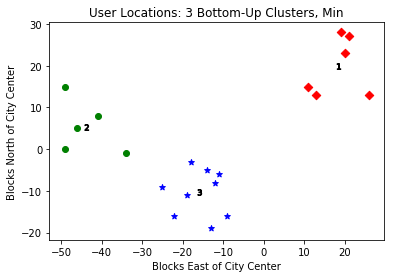

In [30]:
base_cluster = bottom_up_cluster(inputs,distance_agg=max)

# generate 3 clusters
three_clusters = [get_values(cluster)
                  for cluster in generate_clusters(base_cluster,3)]

print(three_clusters)

# plot them
for i,cluster,marker,color in zip([1,2,3],
                                 three_clusters,
                                 ['D','o','*'],
                                 ['r','g','b']):
    xs, ys = zip(*cluster) # unzip
    plt.scatter(xs,ys,color=color,marker=marker)
    
    # put a # @ the mean of the cluster
    x,y = vector_mean(cluster)
    
    plt.plot(x,y,marker='$'+str(i)+'$',color='black')

plt.title('User Locations: 3 Bottom-Up Clusters, Min')
plt.xlabel('Blocks East of City Center')
plt.ylabel('Blocks North of City Center')
plt.show()

`bottom_up_clustering()` implementation = relatively simple, but also shockingly inefficient. In particular, it recomputes distance between each pair of inputs *at every step*. More efficient implementation might *precompute* distances between each pair of inputs + then perform a lookup
inside `cluster_distance()`. A really efficient implementation would likely also remember the `cluster_distances` from the previous step.

### For Further Exploration
* scikit-learn has an entire module sklearn.cluster that contains several clustering algorithms including KMeans + Ward hierarchical clustering algorithm (uses a different criterion for merging clusters than ours did).
* SciPy has 2 clustering models scipy.cluster.vq (which does k-means) + scipy.cluster.hierarchy (variety of hierarchical clustering algorithms)